# TOC

__Lab 04 - Linear regression & feature selection__
1. [Import](#Import)
1. [Linear regression basics](#Linear-regression-basics)
    1. [Example 1 - simple linear regression](#Linear-regression-basics-Example1)
1. [Linear regression w/ gradient descent](#Linear-regression-w/-gradient-descent)
    1. [Example 1 - full gradient descent](#Linear-regression-w/-gradient-descent-Example1)
    1. [Example 2 - stochastic / batch gradient descent](#Linear-regression-w/-gradient-descent-Example2)
1. [Feature selection](#Feature-selection)
    1. [Example 1 - SelectKBest for linear regression - compact](#Feature-selection-Example1)
    1. [Example 2 - SelectKBest for linear regression - detailed](#Feature-selection-Example2)
    1. [Example 3 - feature selection step within pipeline](#Feature-selection-Example3)
1. [Handling missing data](#Handling-missing-data)
    1. [Example 1 - null observations and features](#Handling-missing-data-Example1)
1. [Handling categorical features](#Handling-categorical-features)
    1. [Example 1 - mapping strategies](#Handling-categorical-features-Example1)
1. [Standardizing data: bring features onto same scale](#Standardizing-data:-bring-features-onto-same-scale)
    1. [Example 1 - standardization strategies](#Standardizing-data:-bring-features-onto-same-scale-Example1)


# Import

<a id ='Import'></a>

In [70]:
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:78% !important; }</style>"))

import sys
import csv

from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
    Imputer,
)
from sklearn.metrics import accuracy_score, mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Linear regression basics

Linear regression seeks to fit a line (in 2 dimensions), a plane (in 3 dimensions) or a hyperplane (in 4+ dimensions) to a dataset. The line is fit to a set of $m$ total observations. Each observation has $n$ total features, or dimensions, that describe the observation's characteristics. Typically, the observations are represented as rows in a datset and the features are represented as columns and are captured in an $m \space x \space n$ matrix $X$.

All feature values of a single observation are captured in the vector $\textbf{x}_i$, and each $j$ feature is paired with a weight $w_j$. The full set of weights is contained in a weight vector $\textbf{w}$. The feature values for each observation are combined with their respective weights to produce a prediction for that observation's outcome. The equation for determining the prediction of a single outcome is:

$$
\hat{y}_i = \textbf{w}^T\textbf{x}_i + b
\\
\textrm{where } b \textrm{ is the bias term}
$$ 

The error, or residual, of each prediction is the different between the predicted outcome $\hat{y}_i$ and the actual outcome $y_i$. The line that fits best is the line that minimizes the cumulative error across all predictions. This overall error is captured by a loss (or objective) function, and the goal is to optimize the equation by finding the parameters which minimize the total loss. A typical method for calculating loss is mean squared error (MSE):

$$ 
\begin{equation}
\frac{1}{m}\sum_{i=1}^{m}\left[ (\mathbf{w}^T\mathbf{x}_i + b) - y_i\right]^2,\\
\textrm{where } m \textrm{ is the # of observations}
\end{equation}
$$

The bias term $b$ can be removed from the equation: 

$$
\begin{equation}\tag{1.3}
\frac{1}{m}\sum_{i=1}^{m}\left[ \mathbf{w}^T\mathbf{x}_i - y_i\right]^2
\end{equation}
$$

by 'augmenting' the weight vector and observation feature vectors. To augment the weight vector, the bias unit is inserted into the weight vector $\textbf{w}$ at $w_1$, and observation each sample vector has a 1 placed at $x_{i1}$:

$$
\mathbf{x_i} =
\begin{bmatrix}
\mathbf{1}\\
\mathbf{x_{i2}}\\
\mathbf{...}\\
\mathbf{x_{in+1}}\\
\end{bmatrix},\quad
\boldsymbol{\mathbf{w}} =
\begin{bmatrix}
\mathbf{b}\\
\mathbf{w_2}\\
\mathbf{...}\\
\mathbf{w_{n+1}}\\
\end{bmatrix}
$$


<a id ='Linear-regression-basics'></a>

## Example 1 - simple linear regression

- Calculate ordinary least squares loss on small, made up dataset
- Visualize the line created by the model

<a id = 'Linear-regression-basics-Example1'></a>

__Custom functions__

In [71]:
# custom functions
def plot_2d_models(data, models=[], names=[], title=None):
    fig, ax = plt.subplots()

    ax.plot(data[:, 0], data[:, 1], "o")
    domain = [min(data[:, 0]), max(data[:, 0])]

    for W, label in zip(models, names):
        b, m = W[0], W[1]
        yvals = [m * x + b for x in domain]
        ax.plot(domain, yvals, linewidth=1, label=label)
    if models:
        plt.legend(bbox_to_anchor=(1.05, 1.00), loc=2, borderaxespad=0.0)
    if title:
        plt.title(title)


def augment(X):
    return np.insert(arr=X, obj=0, values=1.0, axis=1)


def ols_loss(X, y, model):
    N = len(X)
    W = np.array(model)
    return 1 / float(N) * sum((W.dot(X.T) - y) ** 2)

In [72]:
# load and inspect data
def getData():
    dfData = {"x": [1, 3, 5, 4, 2], "y": [2, 4, 5, 3, 3]}
    return pd.DataFrame.from_dict(dfData).values


points = getData()

In [73]:
# review observations
X = augment(X=points)[:, :-1]
X

array([[1, 1],
       [1, 3],
       [1, 5],
       [1, 4],
       [1, 2]])

In [74]:
# review labels
y = points[:, -1]
y

array([2, 4, 5, 3, 3])

In [75]:
# calculate loss
print("Loss: {0}".format(ols_loss(X, y, model=[0, 1])))

Loss: 0.8


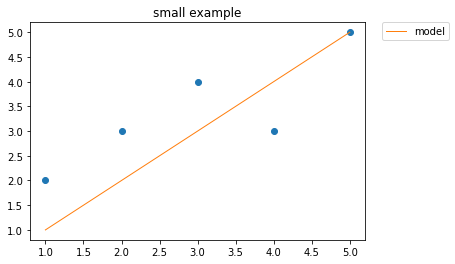

In [76]:
# visualize line fit
plot_2d_models(data=points, models=[[0, 1]], names=["model"], title="small example")

# Linear regression w/ gradient descent

When determing the best model, it is helpful to understand that the data in $X$ is static, and we are observing how the loss of a model varies as we change the weight in $\theta$.

Calculus tells us that the minimums and maximums (when they exists) occur where our function's first derivative = 0. This rule can be extended in higher dimensions by considering a function's gradient vector, which is comprised of partial derivatives. Again, we want all partial derivatives in the gradient to = 0.

A first derivative of 0 tells us that we've reached a minimum or maximum, and the second derivative tells us which one. If the sign of the second derivative is  positive, this indicates that the function is curving upwards and we've reached a minimum. If the sign of the second derivative is negative, we've reached a maximum.

<a id = 'Linear-regression-w/-gradient-descent'></a>

## Example 1 - full gradient descent

To start this process, let's recall our mean squared error (MSE) loss function from above:

$$
\begin{equation}
LOSS_{MSE}(\boldsymbol{\theta}) = \frac{1}{m}\sum_{i=1}^{m}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2
\\
\textrm{where } \theta \textrm{ is equivalent to the } \textbf{w}^T \textrm{ term used previously}
\end{equation}
$$

The first derivative of our loss function gives us our gradient:

$$
\begin{equation}
\nabla_{ LOSS_{MSE}}(\boldsymbol{\theta}) = \frac{2}{m}\,\sum_{i=1}^{m}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right] \cdot \mathbf{x}'
\end{equation}
$$


With gradient descent, we don't need to know the entire surface to determine the optiminum. A way to consider gradient descent is to think about the process of walking down a hill blindfolded. We start at a random location on the error surface, and feel our way down the hill in small steps. We assess the ground around our immediate location and walk in the direction of steepest descent, reassessing along the way. We know we have reached the bottom of the hill (or minimum loss) once there we find a location where the surface around us only slopes upwards.

In the function, ther size of our steps is controlled by a hyperparamter called the learning rate. This process can be summarized in three steps:

1. Initialize our weight vector $\boldsymbol{\theta}$ to a random set of values.
2. Compute the gradient $\nabla_{\theta}f(\boldsymbol{\theta})$
3. Update the parameters: $\theta_{new} = \theta_{old} - \eta \cdot \nabla_{\theta}f(\boldsymbol{\theta})$

<a id = 'Linear-regression-w/-gradient-descent-Example1'></a>

__Custom functions__

In [77]:
# custom functions
def ols_gradient(X, y, model):
    """
    the dot product of the weights and X yields a prediction vector of len(X).
    find the error between the prediction and the actual outcome, a vector of len(X).
    the dot product of errors and the features points toward steepest descent.
    multiply this by 2 divided by the sample size for the update.    
    """
    M = len(X)
    W = np.array(model)
    return 2.0 / M * (W.dot(X.T) - y).dot(X)


def gradient_descent_update(X, y, n_iter, init_model, eta, verbose=False):
    models = [init_model]
    loss = [ols_loss(X, y, init_model)]

    for idx in range(n_iter):
        gradient = ols_gradient(X, y, models[-1])
        update = eta * gradient
        newModel = models[-1] - update
        if verbose:
            print(
                "\nModel {0}: [{1}, {2}]".format(
                    idx, round(models[-1][0], 2), round(models[-1][1], 2)
                )
            )
            print("Loss: {0}".format(loss[-1]))
            print("     >>> gradient: {0}".format(gradient))
            print("     >>> update: {0}".format(update))
        models.append(newModel)
        loss.append(ols_loss(X, y, newModel))
    if verbose:
        print(
            "\nModel {0}: [{1}, {2}]".format(
                idx, round(models[-1][0], 2), round(models[-1][1], 2)
            )
        )
        print("Loss: {0}".format(loss[-1]))
    return np.array(models), loss


def plot_gradient_descent_progress(data, models, loss, lossFunc=ols_loss, show_contours=True):
    # Create figure w/ two subplots
    fig = plt.figure(figsize=plt.figaspect(0.35))
    ax1 = plt.subplot(1, 2, 1)
    ax1.grid(color="grey", linestyle="-", linewidth=0.5, alpha=0.5)
    ax2 = plt.subplot(1, 2, 2)
    ax2.grid(color="grey", linestyle="-", linewidth=0.5, alpha=0.5)
    fig.subplots_adjust(wspace=0.6)

    ##### Problem Domain Space #####

    # plot data
    ax1.plot(data[:, 0], data[:, 1], "o")
    ax1.set_title("Problem Domain Space", fontsize=18)
    ax1.set_xlabel("Input Data")
    ax1.set_ylabel("Output Value")
    domain = [min(data[:, 0]), max(data[:, 0])]

    # plot models
    for idx, W in enumerate(models):
        b, m = W[0], W[1]
        yvals = [m * x + b for x in domain]
        name = "m{0}: {1}".format(idx, round(loss[idx], 2))
        ax1.plot(domain, yvals, label=name, linewidth=1)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    ##### Model Parameter Space #####

    # plot loss for our models
    w1, w0 = models.T
    ax2.plot(w0, w1)
    ax2.plot(w0, w1, "s")
    ax2.set_title("Model Parameter Space", fontsize=18)
    ax2.set_xlabel("W_0 (slope)")
    ax2.set_ylabel("W_1 (intercept)")

    # plot contour lines
    if show_contours:
        # grid parameters -- just a bit larger than models
        w0_min, w0_max = min(w0) * 0.9, max(w0) * 1.1
        w1_min, w1_max = min(w1) * 0.9, max(w1) * 1.2
        w0_step = (w0_max - w0_min) / 20
        w1_step = (w1_max - w1_min) / 20
        # create loss grid for contour plot
        grid_w0, grid_w1 = np.mgrid[w0_min:w0_max:w0_step, w1_min:w1_max:w1_step]
        grid_loss = [
            lossFunc(augment(data)[:, :2], data[:, 1], model)
            for model in zip(grid_w0.flatten(), grid_w1.flatten())
        ]
        grid_loss = np.array(grid_loss).reshape(20, 20)
        # plot loss contours
        topo_levels = np.logspace(
            min(np.log(min(loss)), 0.1), min(np.log(max(loss)) / 10, 20)
        )
        CS = ax2.contour(
            grid_w0,
            grid_w1,
            grid_loss,
            levels=topo_levels,
            cmap="rainbow",
            linewidths=2.0,
            alpha=0.35,
        )

In [78]:
# load  data
points = getData()
X = augment(points)[:, :-1]
y = points[:, -1]

In [79]:
# review observations
X

array([[1, 1],
       [1, 3],
       [1, 5],
       [1, 4],
       [1, 2]])

In [80]:
# review labels
y

array([2, 4, 5, 3, 3])

In [81]:
# execute full gradient descent
n_steps = 5
eta = 0.01
orig_model = [0, 1]

models, loss = gradient_descent_update(X, y, n_steps, orig_model, eta, verbose=True)

print("Searched {0} models...".format(len(models)))
print(
    "Best model: {0}, Loss of best model: {1}".format(
        models[np.argmin(loss)], loss[np.argmin(loss)]
    )
)


Model 0: [0, 1]
Loss: 0.8
     >>> gradient: [-0.8 -0.8]
     >>> update: [-0.008 -0.008]

Model 1: [0.01, 1.01]
Loss: 0.788352
     >>> gradient: [-0.736 -0.576]
     >>> update: [-0.00736 -0.00576]

Model 2: [0.02, 1.01]
Loss: 0.7802907648000001
     >>> gradient: [-0.68672 -0.40512]
     >>> update: [-0.0068672 -0.0040512]

Model 3: [0.02, 1.02]
Loss: 0.7743283143475198
     >>> gradient: [-0.6486784 -0.2747904]
     >>> update: [-0.00648678 -0.0027479 ]

Model 4: [0.03, 1.02]
Loss: 0.7695974695071257
     >>> gradient: [-0.61921741 -0.17541581]
     >>> update: [-0.00619217 -0.00175416]

Model 4: [0.03, 1.02]
Loss: 0.7655928235757341
Searched 6 models...
Best model: [0.03490616 1.02231326], Loss of best model: 0.7655928235757341


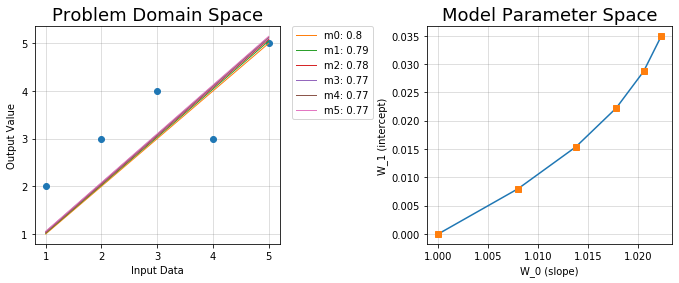

In [82]:
# visualize optimization
show_contours = False
plot_gradient_descent_progress(points, models, loss, show_contours=show_contours)

## Example 2 - stochastic / batch gradient descent

Full gradient descent completes its step only after calculating then gradient of the entiren data set. This is a high-precision approach, but can be resource intensive. An alternative is stochastic descent which uses a subset of the features. This subset can be as small as size 1.

$$
\begin{equation}
\nabla f(\boldsymbol{\theta}) \approx \nabla_{\text{batch}\,\,} f(\boldsymbol{\theta}) = \frac{2}{m}\sum_{i=1}^{m}\left(\mathbf{x}'_{a_i}\cdot \boldsymbol{\theta} - y_{a_i}\right)\cdot \mathbf{x}'_{a_i}
\end{equation}
$$

where $a_i$ is an array of indices of objects which are in this batch. After each iteration, it important to shuffle the samples.

<a id = 'Linear-regression-w/-gradient-descent-Example2'></a>

__Custom functions__

In [83]:
# custom function
def stochastic_gradient_descent_update(X, y, n_iter, B, ]=[, eta, verbose=False):
    models = [init_model]
    loss = [ols_loss(X, y, init_model)]

    m = len(X)
    for idx in range(n_iter):
        j = (idx * B) % m
        batchX, batchy = X[j : j + B], y[j : j + B]
        gradient = ols_gradient(batchX, batchy, models[-1]) / m
        update = eta * gradient
        newModel = models[-1] - update
        if verbose:
            print(
                "\nModel {0}: [{1}, {2}]".format(
                    idx, round(models[-1][0], 2), round(models[-1][1], 2)
                )
            )
            print("Loss: {0}".format(loss[-1]))
            print("     >>> gradient: {0}".format(gradient))
            print("     >>> update: {0}".format(update))
        models.append(newModel)
        loss.append(ols_loss(X, y, newModel))
    if verbose:
        print(
            "\nModel {0}: [{1}, {2}]".format(
                idx, round(models[-1][0], 2), round(models[-1][1], 2)
            )
        )
        print("Loss: {0}".format(loss[-1]))
    return np.array(models), loss

In [84]:
# load  data
points = getData()
X = augment(points)[:, :-1]
y = points[:, -1]

In [85]:
# review observations
X

array([[1, 1],
       [1, 3],
       [1, 5],
       [1, 4],
       [1, 2]])

In [86]:
# review labels
y

array([2, 4, 5, 3, 3])

In [87]:
# execute stochastic gradient descent
n_steps = 5
eta = 0.1
orig_model = [0, 1]
batch_size = 1

models, loss = stochastic_gradient_descent_update(X, y, n_steps, batch_size, orig_model, eta, verbose=True)

print("Searched {0} models...".format(len(models)))
print(
    "Best model: {0}, Loss of best model: {1}".format(
        models[np.argmin(loss)], loss[np.argmin(loss)]
    )
)


Model 0: [0, 1]
Loss: 0.8
     >>> gradient: [-0.4 -0.4]
     >>> update: [-0.04 -0.04]

Model 1: [0.04, 1.04]
Loss: 0.7648
     >>> gradient: [-0.336 -1.008]
     >>> update: [-0.0336 -0.1008]

Model 2: [0.07, 1.14]
Loss: 0.9141452800000004
     >>> gradient: [0.31104 1.5552 ]
     >>> update: [0.031104 0.15552 ]

Model 3: [0.04, 0.99]
Loss: 0.7782153256960003
     >>> gradient: [0.3934464 1.5737856]
     >>> update: [0.03934464 0.15737856]

Model 4: [0.0, 0.83]
Loss: 1.2577106818564097
     >>> gradient: [-0.5364183  -1.07283661]
     >>> update: [-0.05364183 -0.10728366]

Model 4: [0.06, 0.94]
Loss: 0.8337672467910437
Searched 6 models...
Best model: [0.04 1.04], Loss of best model: 0.7648


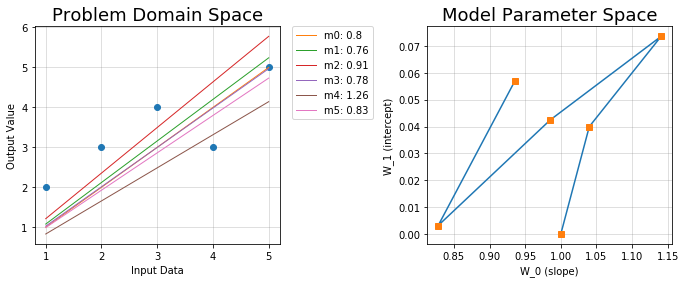

In [88]:
# visualize optimization
show_contours = False
plot_gradient_descent_progress(points, models, loss, show_contours=show_contours)

# Feature selection

Feature selection pertains to strategic variable selection which aims to limit the original data set to only relevant variables. This is advantageous for several reasons:

1. Simpler models are easier to interpet.
2. Model training time is shorter.
3. Avoids curse of dimensionality.
4. Reduces tendency towards high variance due to increased model complexity.

<a id = 'Feature-selection'></a>

## Example 1 - SelectKBest for linear regression - compact

SelectKBest for linear regression employs a test called f_regression.

Then first step is to compute the correlation between each feature and the target.

$$
{\displaystyle \rho _{X,Y}=\mathrm {corr} (X,Y)={\mathrm {cov} (X,Y) \over \sigma _{X}\sigma _{Y}}={E[(X-\mu _{X})(Y-\mu _{Y})] \over \sigma _{X}\sigma _{Y}},}
$$

Python code for this might look something like:

```python
((X[:, i] - mean(X[:, i])) (y - mean_y)) / (std(X[:, i]) std(y))
```


The second step is to use the correlation to calculate the F-score, which is used to calculate the p-value for each feature.

<a id = 'Feature-selection-Example1'></a>

In [89]:
# load data
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [90]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [91]:
# perform SelectKBest
best = SelectKBest(f_regression, k=5)  # k is number of features.
X_trainSel = best.fit_transform(X_train, y_train)

In [92]:
# evaluate feature selection
X_trainSel[0:4, :]

array([[  2.46 ,   6.144, 193.   ,  17.8  ,   9.45 ],
       [ 25.65 ,   5.961, 188.   ,  19.1  ,  17.93 ],
       [  2.89 ,   7.416, 276.   ,  18.   ,   6.19 ],
       [  6.2  ,   6.951, 307.   ,  17.4  ,   9.71 ]])

In [93]:
# review observations
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
181,0.06888,0.0,2.46,0.0,0.488,6.144,62.2,2.5979,3.0,193.0,17.8,396.90,9.45
122,0.09299,0.0,25.65,0.0,0.581,5.961,92.9,2.0869,2.0,188.0,19.1,378.09,17.93
99,0.06860,0.0,2.89,0.0,0.445,7.416,62.5,3.4952,2.0,276.0,18.0,396.90,6.19
220,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,391.70,9.71
474,8.05579,0.0,18.10,0.0,0.584,5.427,95.4,2.4298,24.0,666.0,20.2,352.58,18.14


>  Features retained: INDUS, RM, TAX, PTRATIO, LSAT

## Example 2 - SelectKBest for linear regression - detailed

Using Boston housing market dataset:
- Use custom function to perform SelectKBest and log supporting statistics including F-scores and p-values in a DataFrame
- Visualize feature importance according to F-score


<a id = 'Feature-selection-Example2'></a>

__Custom functions__

In [94]:
# custom function
def select_k_best_ref(dataFrame, target, k=5):
    """
    
    """
    featSelector = SelectKBest(f_regression, k=k)
    _ = featSelector.fit(dataFrame.drop(target, axis=1), dataFrame[target])

    feat_scores = pd.DataFrame()
    feat_scores["F score"] = featSelector.scores_
    feat_scores["P value"] = featSelector.pvalues_
    feat_scores["Support"] = featSelector.get_support()
    feat_scores["Attribute"] = dataFrame.drop(target, axis=1).columns

    return feat_scores

In [95]:
# load data
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [96]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [97]:
# combine train data info DataFrame
df = pd.DataFrame(X_train, columns=boston.feature_names)
df["MEDV"] = y_train

In [98]:
# perform SelectKBest
feat_scores = select_k_best_ref(df, "MEDV", k=7)

In [99]:
# evaluate feature selection
feat_scores_sorted = feat_scores.sort_values(
    ["F score", "P value"], ascending=[False, False]
)
print("Feature Score for a linear regression using correlation \n")
print(feat_scores_sorted)

Feature Score for a linear regression using correlation 

       F score       P value  Support Attribute
12  474.974942  4.373435e-70     True     LSTAT
5   388.685106  5.050989e-61     True        RM
10  124.931223  1.930196e-25     True   PTRATIO
2   116.026814  6.101575e-24     True     INDUS
9   107.274933  1.931385e-22     True       TAX
4    85.039143  1.669887e-18     True       NOX
0    73.732715  1.987020e-16     True      CRIM
8    64.861115  9.213851e-15    False       RAD
6    55.681364  5.318242e-13    False       AGE
1    50.485143  5.502609e-12    False        ZN
11   46.254397  3.774453e-11    False         B
7    22.794055  2.529681e-06    False       DIS
3     7.902266  5.178888e-03    False      CHAS


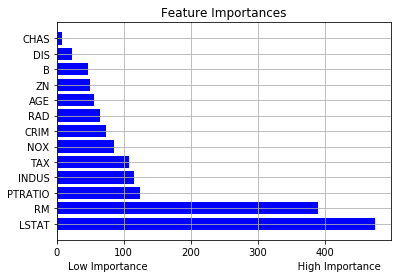

In [100]:
# visualize top features
feat_importance_sorted = feat_scores_sorted[["F score", "Attribute"]]

plt.figure()
plt.title("Feature importances")

sorted_names = np.array(feat_importance_sorted)[:, 1]
sorted_importance = np.array(feat_importance_sorted)[:, 0]

plt.title("Feature Importances")
plt.barh(range(len(sorted_names)), sorted_importance, color="b", align="center")
plt.yticks(range(len(sorted_names)), sorted_names)
plt.xlabel(
    "Low Importance                                                High Importance"
)
plt.grid()
plt.show()

## Example 3 - feature selection step within pipeline

Using Boston housing market dataset:
- With feature importance F-scores determined in previous example, use custom functions to perform SelectKBest within a pipeline
- Evaluate model using test set
- Visualize coefficients of selected columns

<a id = 'Feature-selection-Example3'></a>

__Custom functions__

In [101]:
# custom functions
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, featureImportance, k):
        self.featureImportance = featureImportance
        self.k = k

    def fit(self, X, y=None):
        self.featureIndices_ = indices_of_top_k(self.featureImportance, self.k)
        return self

    def transform(self, X):
        return X[:, self.featureIndices_]

In [102]:
# load data
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [103]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [104]:
# combine train data info DataFrame
df = pd.DataFrame(X_train, columns=boston.feature_names)
df["MEDV"] = y_train

In [105]:
# calculate feature F-scores
feat_scores = select_k_best_ref(df, "MEDV", k=7)
featureFScores = feat_scores[["F score"]].values.flatten()
featureFScores

array([ 73.73271485,  50.48514331, 116.02681424,   7.90226593,
        85.03914291, 388.68510611,  55.6813643 ,  22.79405499,
        64.86111507, 107.27493269, 124.93122263,  46.25439733,
       474.97494162])

In [106]:
# create pipeline - Scale data, performs SelectKBest, and train linear regression model
pipeline = Pipeline(
    [
        ("stdScaler", StandardScaler()),
        (
            "featureSelection",
            TopFeatureSelector(featureFScores, k="featureSelection__k"),
        ),
        ("lin_reg", LinearRegression()),
    ]
)

In [107]:
# build parameter grid
param_grid = {"featureSelection__k": np.arange(1, len(featureFScores) + 1)}
param_grid

{'featureSelection__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])}

In [108]:
# run GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, refit=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('stdScaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('featureSelection',
                                        TopFeatureSelector(featureImportance=array([ 73.73271485,  50.48514331, 116.02681424,   7.90226593,
        85.03914291, 388.68510611,  55.6813643 ,  22.79405499,
        64.86111507, 107.27493269, 124.93122263,  46.25439733,
       474.97494162]),
                                                           k='featureSelection__k')),
                                       ('lin_reg',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
        

In [109]:
# evaluate GridSearchCV
print("Best score: {0}".format(grid_search.best_score_))
print("Best parameter: {0}".format(grid_search.best_params_))
print("Best estimator: {0}".format(grid_search.best_estimator_))

Best score: 0.706679636548946
Best parameter: {'featureSelection__k': 13}
Best estimator: Pipeline(memory=None,
         steps=[('stdScaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('featureSelection',
                 TopFeatureSelector(featureImportance=array([ 73.73271485,  50.48514331, 116.02681424,   7.90226593,
        85.03914291, 388.68510611,  55.6813643 ,  22.79405499,
        64.86111507, 107.27493269, 124.93122263,  46.25439733,
       474.97494162]),
                                    k=13)),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)


In [110]:
# test set predictions
y_preds_test = grid_search.predict(X_test)
print(
    "Test accuracy (MSE): {0}".format(
        np.round(mean_squared_error(y_test, y_preds_test), 3)
    )
)
print(
    "Test accuracy (RMSE): {0}".format(
        np.round(np.sqrt(mean_squared_error(y_test, y_preds_test)), 3)
    )
)

Test accuracy (MSE): 23.677
Test accuracy (RMSE): 4.866


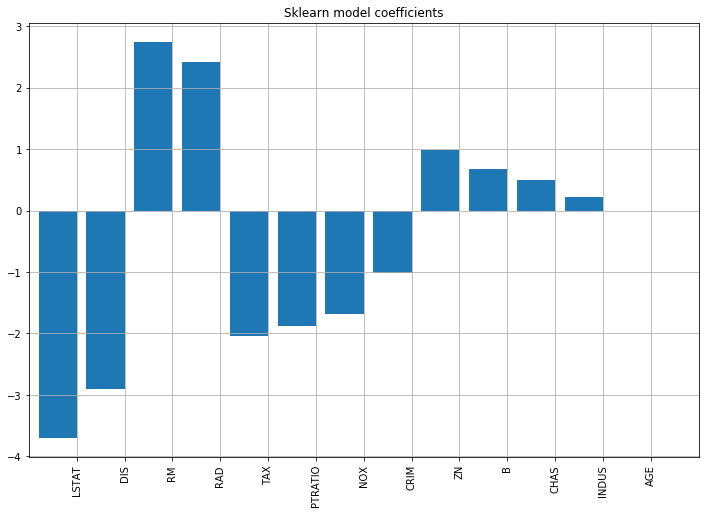

In [111]:
# visualize
model = grid_search.best_estimator_.named_steps["lin_reg"]

feat_scores = pd.DataFrame()
feat_scores["coefficient"] = model.coef_
feat_scores["ABScoefficient"] = np.abs(model.coef_)
feat_scores["Attribute"] = X.columns
feat_scores = feat_scores.sort_values(["ABScoefficient"], ascending=[False])
feat_scores

plt.figure(figsize=(12, 8))
plt.bar(np.arange(model.coef_.shape[0]) - 0.4, feat_scores["coefficient"])
plt.xticks(
    np.arange(model.coef_.shape[0]), feat_scores["Attribute"], rotation="vertical"
)
plt.xlim([-1, model.coef_.shape[0]])
plt.grid()
plt.title("Sklearn model coefficients")

# Handling missing data

Observations are often missing data for one or more features. Similarly, features often contain nulls for several observations. Missing data is problematic for machine learning algorithms it can cause errors in calculations. There are several methods to deal with nulls, and while no method is perfect, the context of the nulls can help determine the best course of action.

<a id = 'Handling-missing-data'></a>

## Example 1 - null observations and features

Dropping feature and/or observations is as straight forward as it sounds. The downside to this approach is that dropping data means less data is available for the algorithm to model the problem. Dropping features or columns is generally not advised as a first step.

<a id = 'Handling-missing-data-Example1'></a>

In [112]:
# load and inspect data
import pandas as pd
from io import StringIO
import sys

csv_data = """A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,"""

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [113]:
# inspect null counts
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

__Strategy 1: Eliminate data__

In [114]:
# observations with any missing values
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [115]:
# features with any missing values
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [116]:
# rows where all columns are null
df.dropna(how="all")

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [117]:
# rows must have 3 or more real values populated
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [118]:
# only drop rows with nulls in specified column
df.dropna(subset=["C"])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


__Strategy 1: Imputing missing values__

Use a predefined strategy to fill in null values with an inferred value. Common strategies include fill feature nulls with the mean, median or most common value.

In [119]:
# review missing values
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [120]:
# fill nulls with column mean
imr = Imputer(missing_values="NaN", strategy="mean", axis=0)
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

# Handling categorical features

Machine learning algorithms require numerical data, but we are often provided with features that are described with text values. Such value can be nominal or ordinal:

nominal: Male, Female

ordinal: S, M, L, XL

Nominal and ordinal features need to be handled differently.

<a id = 'Handling-categorical-features'></a>

## Example 1 - mapping strategies


<a id = 'Handling-categorical-features-Example1'></a>

In [121]:
# load and inspect data

df = pd.DataFrame(
    [
        ["green", "M", 10.1, "class1"],
        ["red", "L", 13.5, "class2"],
        ["blue", "XL", 15.3, "class1"],
    ]
)

df.columns = ["color", "size", "price", "classlabel"]
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


__Strategy 1: preserve hierarchy of ordinal features__

In [122]:
# map
size_mapping = {"XL": 3, "L": 2, "M": 1}

In [123]:
# apply mapping
df["size"] = df["size"].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [124]:
# reverse mapping
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df["size"].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

__Strategy 2: manually encode class labels__

In [125]:
# dynamically build encoding dictionary
class_mapping = {label: idx for idx, label in enumerate(np.unique(df["classlabel"]))}
class_mapping

{'class1': 0, 'class2': 1}

In [126]:
# apply mapping
df["classlabel"] = df["classlabel"].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [127]:
# reverse mapping
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df["classlabel"].map(inv_class_mapping)

0    class1
1    class2
2    class1
Name: classlabel, dtype: object

__Strategy 3: encode class labels with sklearn__

In [128]:
# instantiate encoder and apply
class_le = LabelEncoder()
y = class_le.fit_transform(df["classlabel"].values)
y

array([0, 1, 0])

In [129]:
# reverse transformation
class_le.inverse_transform(y)

array([0, 1, 0])

__Strategy 4: one-hot encoding__

In [130]:
# create dummy dataset and encode
df = pd.DataFrame(
    [
        ["green", "M", 10.1, "class1"],
        ["red", "L", 13.5, "class2"],
        ["blue", "XL", 15.3, "class1"],
    ]
)

df.columns = ["color", "size", "price", "classlabel"]

size_mapping = {"XL": 3, "L": 2, "M": 1}
df["size"] = df["size"].map(size_mapping)

X = df[["color", "size", "price"]].values

color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [131]:
# encode using sklearn OneHot Encoder
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

__Strategy 5: get dummies__

In [132]:
# encode using get_dummies()
pd.get_dummies(df[["price", "color", "size"]])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [133]:
# avoid multicollinearity by dropping one of the dummy columns for each mapped feature
pd.get_dummies(df[["price", "color", "size"]], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


# Standardizing data: bring features onto same scale

Standardizing the features ensures that each feature is given equal consideration in the training phase. Without standarization, some features may play a more prominent role in model training simply because the values are higher, but not necessarily because the feature is more important than another feature that happens to have smaller values.

Several machine learning algorithms require data to be scaled.

<a id = 'Standardizing-data:-bring-features-onto-same-scale'></a>

## Example 1 - standardization strategies

A couple basic standardization strategies. 
- Standard scaling - scale the data so that it has the properties of a standard normal distribution - a mean of 0 and a standard deviation of 1
- Min/max scaling - scale the data so that is fits in a set range, usually 0 - 1. 

<a id = 'Standardizing-data:-bring-features-onto-same-scale-Example1'></a>

In [134]:
# load data
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [135]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

__Strategy 1 - min/max scaling__

In [136]:
# instantiate min/max scaler and transform
mms = MinMaxScaler()
X_trainNorm = mms.fit_transform(X_train)
X_testNorm = mms.transform(X_test)

__Strategy 2 - standard scaling__

In [137]:
# strategy 2 - standard scaling
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [138]:
# compare scaling strategies
ex = np.array([0, 1, 2, 3, 4, 5])

print("standardized:", (ex - ex.mean()) / ex.std())

print("normalized:", (ex - ex.min()) / (ex.max() - ex.min()))

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalized: [0.  0.2 0.4 0.6 0.8 1. ]
